In [36]:
import matplotlib
import numpy as np
import pysptk
from scipy.io import wavfile
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa
import librosa.display

## Load audio file

In [37]:
fs, x = wavfile.read(pysptk.util.example_audio_file())
assert fs == 16000
x = x.astype(np.float64)
print(x.shape)

(64000,)


Text(0.5, 1.0, 'raw waveform of example audio file')

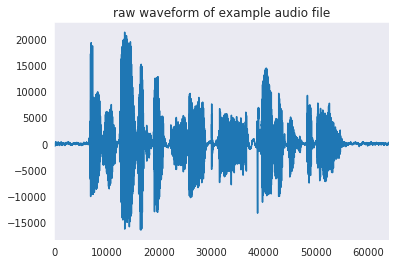

In [38]:
plt.plot(x)
xlim(0, len(x))
title("raw waveform of example audio file")

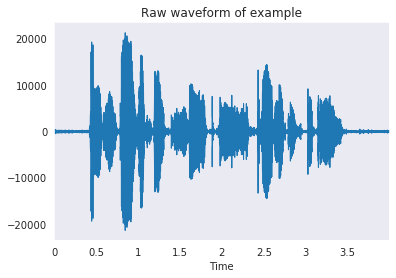

In [41]:
librosa.display.waveplot(x, sr=fs)
title("Raw waveform of example")
Audio(x, rate=fs)

# Windowing

Text(0.5, 1.0, 'a windowd time frame')

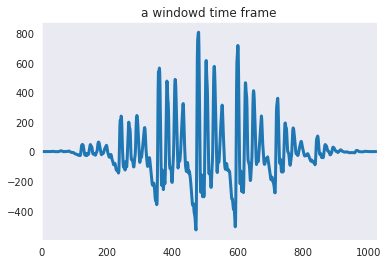

In [63]:
#short sagment
pos = 40000
frame_length = 1024
hop_length = 80

frames = librosa.util.frame(x, frame_length=frame_length, hop_length=hop_length).astype(np.float64).T

# frames = x[pos:pos+frame_length] * pysptk.blackman(frame_length)

frames *= pysptk.blackman(frame_length)

assert frames.shape[1] == frame_length

plot(xw, linewidth = 3.0)
xlim(0, frame_length)
title("a windowd time frame")

(0, 800)

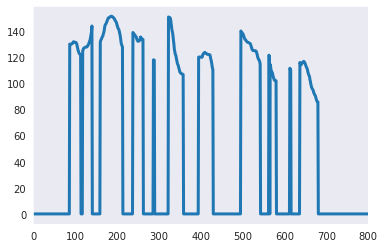

In [64]:
f0 = pysptk.swipe(x.astype(np.float64), fs = fs, hopsize=hop_length, min = 60, max = 240, otype="f0")
plt.plot(f0, linewidth=3)
xlim(0, len(f0))


In [65]:
## Source excitation generation

(-2, 16)

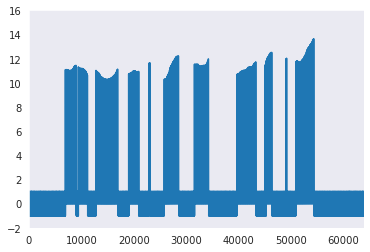

In [66]:
pitch = pysptk.swipe(x.astype(np.float64), fs = fs, hopsize=hop_length, min = 60, max = 240, otype="pitch")
source_excitation = pysptk.excite(pitch, hop_length)

plt.plot(source_excitation, label="Source")
xlim(0, len(source_excitation))
ylim(-2, 16)

In [67]:
##Synthesis from mel-cepstrum

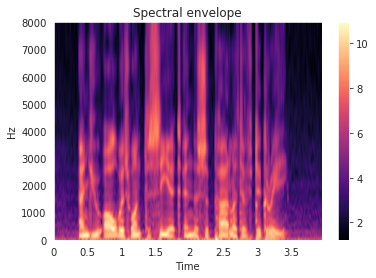

In [68]:
order = 25
alpha = 0.41

mc = pysptk.mcep(frames, order, alpha)
logH = pysptk.mgc2sp(mc, alpha, 0.0, frame_length).real
librosa.display.specshow(logH.T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear")
colorbar()
title("Spectral envelope");

In [ ]:
## Source excitation generation

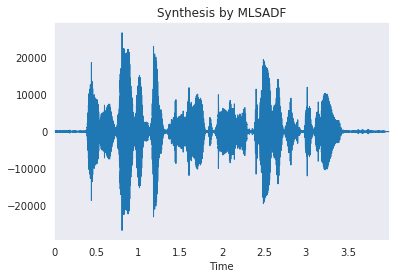

In [72]:
from pysptk.synthesis import MLSADF, Synthesizer

# Convert mel-cepstrum to MLSADF coefficients

b = pysptk.mc2b(mc, alpha)

synthesizer = Synthesizer(MLSADF(order=order, alpha=alpha), hop_length)

x_synthesized = synthesizer.synthesis(source_excitation, b)

librosa.display.waveplot(x_synthesized, sr = fs)
title("Synthesis by MLSADF")
Audio(x_synthesized, rate=fs)

In [ ]:
## Synthesis from cepstrum

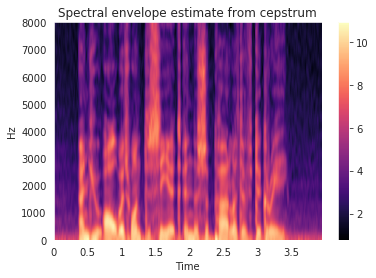

In [74]:
# Order of mel-cepstrum
order = 25

c = pysptk.mcep(frames, order, 0.0)

logH = pysptk.mgc2sp(c, 0.0, 0.0, frame_length).real
librosa.display.specshow(logH.T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear")
colorbar()
title("Spectral envelope estimate from cepstrum");


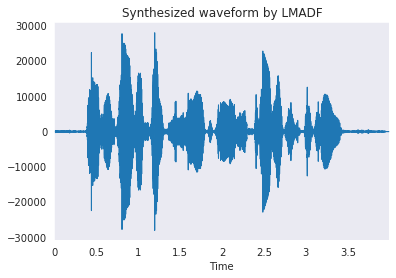

In [77]:


from pysptk.synthesis import LMADF

synthesizer = Synthesizer(LMADF(order=order), hop_length)

x_synthesized = synthesizer.synthesis(source_excitation, c)

librosa.display.waveplot(x_synthesized, sr=fs)
title("Synthesized waveform by LMADF")
Audio(x_synthesized, rate=fs);



In [ ]:
## Synthesis from mel-generalized cepstrum

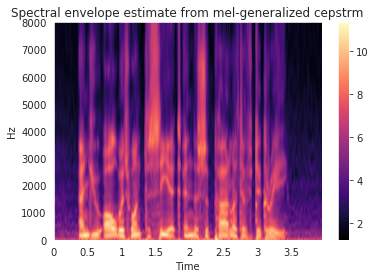

In [78]:
# Order of mel-cepstrum
order = 25
alpha = 0.41
stage = 5
gamma = -1.0 / stage

mgc = pysptk.mgcep(frames, order, alpha, gamma)

logH = pysptk.mgc2sp(mgc, alpha, gamma, frame_length).real
librosa.display.specshow(logH.T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear")
colorbar()
title("Spectral envelope estimate from mel-generalized cepstrm");



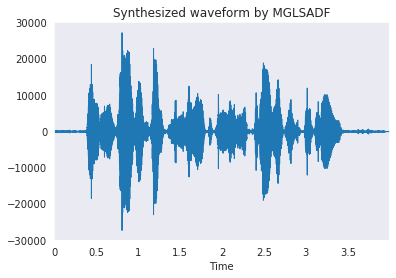

In [81]:


from pysptk.synthesis import MGLSADF

# Convert mel-generalized cesptrum to MGLSADF coefficients
b = pysptk.mgc2b(mgc, alpha, gamma)

synthesizer = Synthesizer(MGLSADF(order=order, alpha=alpha, stage=stage), hop_length)

x_synthesized = synthesizer.synthesis(source_excitation, b)

librosa.display.waveplot(x_synthesized, sr=fs)
title("Synthesized waveform by MGLSADF")
Audio(x_synthesized, rate=fs)



In [ ]:
## Synthesis from LPC

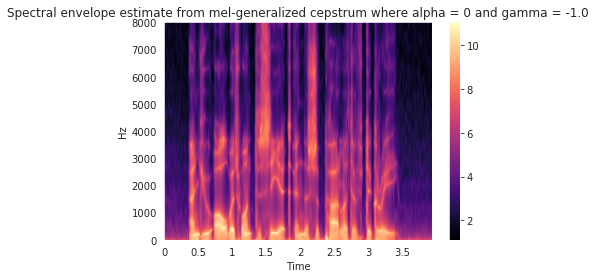

In [82]:
#Order of mel-cepstrum
order = 25

# apply function along with `time` axis (=1)
mgc = pysptk.mgcep(frames, order, 0.0, -1.0)

logH = pysptk.mgc2sp(mgc, 0.0, -1.0, frame_length).real
librosa.display.specshow(logH.T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear")
colorbar()
title("Spectral envelope estimate from mel-generalized cepstrum where alpha = 0 and gamma = -1.0");



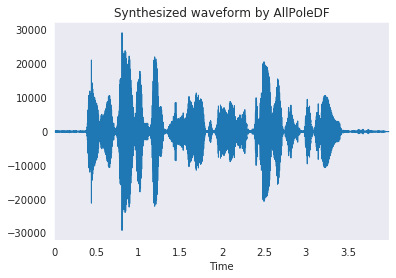

In [84]:
from pysptk.synthesis import AllPoleDF

lpc = pysptk.lpc(frames, order)

# make sure lpc has loggain
lpc[:, 0] = np.log(lpc[:, 0])

synthesizer = Synthesizer(AllPoleDF(order=order), hop_length)

x_synthesized = synthesizer.synthesis(source_excitation, lpc)

librosa.display.waveplot(x_synthesized, sr=fs)
title("Synthesized waveform by AllPoleDF")
Audio(x_synthesized, rate=fs)